### Setup

In [1]:
import tensorflow as tf

2023-02-16 19:27:20.862723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-02-16 19:27:22.948608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 19:27:22.966291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 19:27:22.966480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.train import Checkpoint

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
DATA_PATH = "images"
ROOT_PATH = '/home/guillaume/code/35m5loKiUe/WGAN_DATA/'
PREPROC_PATH = 'preproc'
CHECKPOINT_PATH = 'training_checkpoints'
GIF_PATH = 'gif_pics'

NB_FILTERS = 256
IMAGE_SIZE = 128
BUFFER_SIZE = 60000
BATCH_SIZE = 128
NB_CONVOL_GEN = 4
NB_CONVOL_DISC = 3

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOT_PATH, DATA_PATH),
    label_mode=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
)
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
train_dataset = train_dataset.map(lambda x: (normalization_layer(x)))

Found 25663 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-16 19:27:27.992625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 19:27:27.993536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 19:27:27.993826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 19:27:27.993970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [7]:
#def make_generator_model(IMAGE_SIZE):
#    
#    model = tf.keras.Sequential()
#    
#    first_dim = int(IMAGE_SIZE/8)
#    
#    model.add(layers.Dense(256*first_dim**2, use_bias=False, input_shape=(100,)))
#    model.add(layers.BatchNormalization())
#    model.add(layers.LeakyReLU())
#
#    model.add(layers.Reshape((first_dim, first_dim, 256)))
#    
#    model.add(layers.Conv2DTranspose(4*IMAGE_SIZE, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#    model.add(layers.BatchNormalization())
#    model.add(layers.LeakyReLU())    
#
#    model.add(layers.Conv2DTranspose(2*IMAGE_SIZE, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#    model.add(layers.BatchNormalization())
#    model.add(layers.LeakyReLU())
#    
#    model.add(layers.Conv2DTranspose(IMAGE_SIZE, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#    model.add(layers.BatchNormalization())
#    model.add(layers.LeakyReLU())
#    
#    model.add(layers.Conv2DTranspose(IMAGE_SIZE, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#    model.add(layers.BatchNormalization())
#    model.add(layers.LeakyReLU())    
#
#    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
#
#
#    return model

In [8]:
def make_generator_model(IMAGE_SIZE, NB_FILTERS, NB_CONVOL_GEN):
    model = tf.keras.Sequential()
    
    init_img_size = int((IMAGE_SIZE / 2**NB_CONVOL_GEN))
        
    # Dense layer to get sufficient dimensions to create 1st convolution
    model.add(layers.Dense(init_img_size * init_img_size * NB_FILTERS, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Reshape for 1st convolution
    model.add(layers.Reshape((init_img_size, init_img_size, NB_FILTERS)))
    
    #Transpose convolution layers
    for i in range(1, NB_CONVOL_GEN+1):      
        model.add(layers.Conv2DTranspose(NB_FILTERS/2**i, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
    
    #Last convolution layer to return
    model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation=None))
    model.add(layers.Activation('tanh'))

    return model

Use the (as yet untrained) generator to create an image.

In [9]:
generator = make_generator_model(IMAGE_SIZE, NB_FILTERS, NB_CONVOL_GEN)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

2023-02-16 19:27:36.560291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-16 19:27:36.671464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      5

### The Discriminator

The discriminator is a CNN-based image classifier.

In [11]:
def make_discriminator_model(NB_CONVOL_DISC):
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #Transpose convolution layers
    for i in range(0, NB_CONVOL_DISC):      
        model.add(layers.Conv2D(NB_FILTERS/2**i, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
      
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [12]:
discriminator = make_discriminator_model(NB_CONVOL_DISC)

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       409856    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)      

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [18]:
checkpoint_dir = os.path.join(ROOT_PATH, CHECKPOINT_PATH)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [19]:
EPOCHS = 1000
noise_dim = 100
grid_display_size = 3
#num_examples_to_generate = 25

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([grid_display_size**2, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(grid_display_size, grid_display_size, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig(os.path.join(ROOT_PATH, GIF_PATH,'image_at_epoch_{:04d}.png').format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


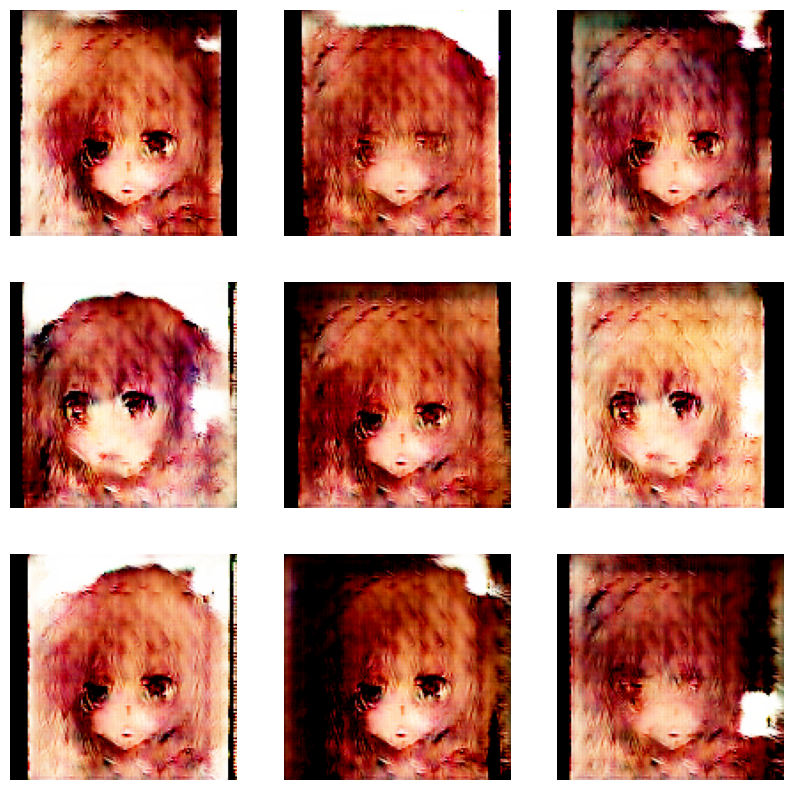

Time for epoch 109 is 61.60675382614136 sec


KeyboardInterrupt: 

In [23]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
